## To gather the citations iterating through all the sheets of the excel file

In [ ]:
pip install Scholarly

In [ ]:
import pandas as pd
import time
from scholarly import scholarly, MaxTriesExceededException

def get_citation_count(paper_title):
    try:
        # Search for the paper by title
        search_query = scholarly.search_pubs(paper_title)

        # Retrieve the first result from the search query
        paper = next(search_query)

        # Extract the number of citations
        citation_count = paper['num_citations']

        return citation_count
    except MaxTriesExceededException:
        print(f"Max tries exceeded for: {paper_title}")
        return None
    except StopIteration:
        print(f"Paper not found: {paper_title}")
        return None
    except Exception as e:
        print(f"An error occurred for {paper_title}: {e}")
        return None

# Specify the path to your Excel file
file_path = 'STI Paper Citation Reports 2023.xlsx'

# Load the Excel file
xls = pd.ExcelFile(file_path)

# Iterate through all sheet names
for sheet_name in xls.sheet_names:
    # Load the specified sheet from the Excel file
    df = pd.read_excel(file_path, sheet_name=sheet_name)

    # Specify the column name
    column_name = 'Paper Title'

    # Create a new column for citations if it doesn't already exist
    if 'Citations from Google Scholar' not in df.columns:
        df['Citations from Google Scholar'] = None

    # Print each row's value for the specified column
    for i, (index, value) in enumerate(df[column_name].items(), start=1):
        citation_count = get_citation_count(value)
        df.at[index, 'Citations from Google Scholar'] = citation_count
        print(f"{i} : {value} - {citation_count}")

        # Add a delay between requests
        time.sleep(10)  # Adjust the delay as needed

    # Save the updated DataFrame back to the Excel file
    df.to_excel(file_path, sheet_name=sheet_name, index=False)

## To create a summary sheet in the Excel

In [ ]:
import openpyxl

# Load the existing Excel file
file_path = 'STI Paper Citation Reports.xlsx'
wb = openpyxl.load_workbook(file_path)

# Create a new sheet for the summary
summary_sheet = wb.create_sheet(title="Summary of previous Iterations")

# Write the header row
summary_sheet.append(["SL.", "Year", "Total number of Citations"])

# Initialize variables
years = ["2019", "2020", "2021", "2022", "2023"]
total_citations_per_year = {year: 0 for year in years}

# Iterate through each sheet to calculate the total citations per year
for sheet_name in wb.sheetnames:
    if sheet_name != "Summary of previous Iterations":
        sheet = wb[sheet_name]
        # Extract year from sheet name
        sheet_year = sheet_name.split()[-1]
        if sheet_year in years:
            # Find the column index for "Citations from Google Scholar"
            header = [cell.value for cell in sheet[1]]
            citation_col_idx = header.index("Citations from Google Scholar") + 1
            for row in sheet.iter_rows(min_row=2, max_col=citation_col_idx, values_only=True):
                citation_count = row[citation_col_idx - 1]
                if isinstance(citation_count, int):
                    total_citations_per_year[sheet_year] += citation_count

# Write the summary data to the new sheet
for idx, year in enumerate(years, start=1):
    summary_sheet.append([idx, year, total_citations_per_year[year]])

# Save the modified Excel file
wb.save(file_path)
print("Summary sheet created and saved successfully.")


## To create bar plot of each sheets (Paper title, Citations)

In [ ]:
import matplotlib.pyplot as plt

# Specify the path to your Excel file
file_path = 'STI Paper Citation Reports 2023 (citation_update).xlsx'

# Load the Excel file
xls = pd.ExcelFile(file_path)

# Iterate through all sheet names
for sheet_name in xls.sheet_names:
    # Load the specified sheet from the Excel file
    data = pd.read_excel(file_path, sheet_name=sheet_name)

    # Check if the "Citations from Google Scholar" column exists
    if 'Citations from Google Scholar' not in data.columns:
        print(f"Skipping sheet {sheet_name} as it does not contain 'Citations from Google Scholar' column.")
        continue

    # Sort the data by citations in descending order and select top 30
    top_30 = data.sort_values(by='Citations from Google Scholar', ascending=False).head(30)

    # Shorten titles for the plot
    top_30['Short Title'] = top_30['Paper Title'].apply(lambda x: ' '.join(x.split()[:4]) + '...')

    # Create a horizontal bar plot
    plt.figure(figsize=(10, 8))
    plt.barh(top_30['Short Title'], top_30['Citations from Google Scholar'], color='skyblue')
    plt.xlabel('Citations')
    plt.title(f'Top 30 Cited Papers of {sheet_name}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest citations at the top
    plt.tight_layout()

    # Save the plot as an image file
    plt.savefig(f'Top_30_Cited_Papers_of_{sheet_name}.png')

    # Show the plot
    plt.show()


## To visualize the summary of total citations

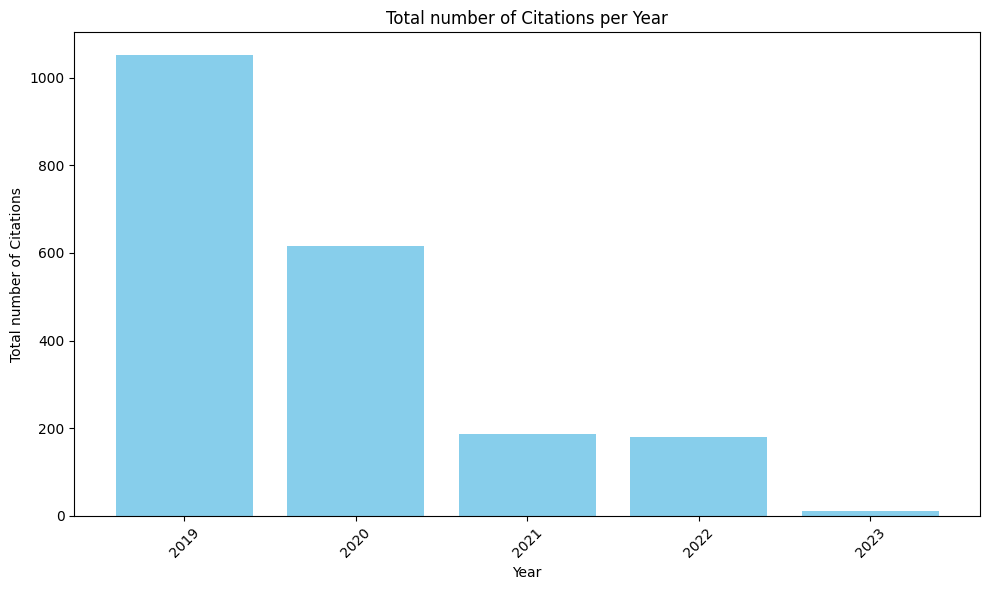

In [ ]:
import openpyxl
import matplotlib.pyplot as plt

# Load the existing Excel file
file_path = 'STI Paper Citation Reports.xlsx'
wb = openpyxl.load_workbook(file_path)

# Select the summary sheet
summary_sheet = wb["Summary of previous Iterations"]

# Read the data from the summary sheet
years = []
citations = []

for row in summary_sheet.iter_rows(min_row=2, values_only=True):
    years.append(row[1])
    citations.append(row[2])

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(years, citations, color='skyblue')
plt.xlabel('Year')
plt.ylabel('Total number of Citations')
plt.title('Total number of Citations per Year')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()
